In [21]:
import os
import json
from tqdm import tqdm

def convert_imcoords_to_bbox(imcoords):
    # imcoords는 문자열 형태의 좌표를 파싱하여 리스트로 변환
    coords = list(map(float, imcoords.split(',')))
    x_values = coords[0::2]  # 짝수 인덱스는 x 좌표
    y_values = coords[1::2]  # 홀수 인덱스는 y 좌표
    
    # 좌표로부터 bbox의 중심 좌표(cx, cy), 너비(width), 높이(height) 계산
    x_min = min(x_values)
    x_max = max(x_values)
    y_min = min(y_values)
    y_max = max(y_values)
    
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min
    
    return cx, cy, width, height

def filter_and_modify_json(directory, output_directory):
    # 지정된 디렉토리 내 모든 JSON 파일 확인
    for filename in tqdm(os.listdir(directory), desc="Processing files", unit="file"):
        if filename.endswith(".json"):
            input_file_path = os.path.join(directory, filename).replace('\\', '/')
            
            with open(input_file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
            
            # 새로운 피처 저장 리스트
            filtered_features = []

            # 'features' 필드가 있는지 확인하고 반복
            if 'features' in data:
                for feature in data['features']:
                    if 'properties' in feature:
                        type_name = feature['properties'].get('type_name')
                        
                        # 'type_name'이 'ship(S)' 또는 'ship(L)'인 경우만 처리
                        if type_name in ['ship(S)', 'ship(L)']:
                            imcoords = feature['properties'].get('object_imcoords')
                            if imcoords:
                                # 좌표 변환 후 새로운 값 추가
                                cx, cy, width, height = convert_imcoords_to_bbox(imcoords)
                                feature['properties']['cx'] = cx
                                feature['properties']['cy'] = cy
                                feature['properties']['width'] = width
                                feature['properties']['height'] = height
                                
                                # 기존 데이터와 함께 새로운 properties로 업데이트
                                filtered_features.append(feature)

            # 새로운 JSON 구조 생성
            if filtered_features:
                new_data = {
                    "type": "FeatureCollection",
                    "features": filtered_features
                }

                # 출력 경로 설정 (출력 폴더에 저장)
                output_file_path = os.path.join(output_directory, filename).replace('\\', '/')
                with open(output_file_path, 'w', encoding='utf-8') as outfile:
                    json.dump(new_data, outfile, ensure_ascii=False, indent=4)
import os
import json

def check_for_other_classes(directory):
    other_classes_found = False
    other_classes = set()

    # 지정된 디렉토리 내 모든 JSON 파일 확인
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename).replace('\\', '/')
            
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
            
            # 'features' 필드가 있는지 확인하고 반복
            if 'features' in data:
                for feature in data['features']:
                    if 'properties' in feature:
                        type_name = feature['properties'].get('type_name')
                        
                        # 'ship(S)' 또는 'ship(L)' 외의 다른 클래스가 있는지 확인
                        if type_name not in ['ship(S)', 'ship(L)']:
                            other_classes_found = True
                            other_classes.add(type_name)

    # 결과 출력
    if other_classes_found:
        print("다른 클래스가 발견되었습니다:", other_classes)
    else:
        print("모든 JSON 파일이 'ship(S)' 또는 'ship(L)'만 포함하고 있습니다.")

In [51]:
import os
import cv2
import json
from tqdm import tqdm


def crop_and_resize_images_and_labels(json_path, img_path, save_img_dir, save_label_dir):
    if not os.path.exists(save_img_dir):
        os.makedirs(save_img_dir)
    if not os.path.exists(save_label_dir):
        os.makedirs(save_label_dir)

    for filename in tqdm(os.listdir(json_path), desc="Processing files", unit="file"):
        png_file = filename.replace('.json', '.png')
        png_file = os.path.join(img_path, png_file).replace('\\', '/')

        if os.path.exists(png_file):
            img = cv2.imread(png_file)
            height, width = img.shape[:2]
            if height != 1024 or width != 1024:
                print(f"Warning: {png_file} is not 1024x1024 size!")
                continue

            json_file_path = os.path.join(json_path, filename)
            with open(json_file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            crops = []
            for i in range(2):  # 0, 1 (세로 방향)
                for j in range(2):  # 0, 1 (가로 방향)
                    start_x = j * 512
                    start_y = i * 512
                    end_x = start_x + 512
                    end_y = start_y + 512

                    new_labels = []
                    for feature in data['features']:
                        if 'properties' in feature:
                            coords = feature['properties'].get('object_imcoords', '')
                            if coords:
                                coords = list(map(float, coords.split(',')))

                                # 좌표가 4쌍(8개)인지 확인
                                if len(coords) == 8:
                                    new_coords = []
                                    for idx in range(0, len(coords), 2):
                                        x = coords[idx]
                                        y = coords[idx + 1]

                                        # 크롭된 이미지의 좌표가 포함되는지 확인
                                        if start_x <= x < end_x and start_y <= y < end_y:
                                            new_coords.append(x - start_x)
                                            new_coords.append(y - start_y)

                                    if len(new_coords) == 8:  # 변환된 좌표가 8개인지 확인
                                        # 객체의 type을 추출
                                        angle = feature['properties'].get('object_angle', 0.0)
                                        new_labels.append({
                                            'type': feature['properties'].get('type', ''),
                                            'object_imcoords': new_coords,
                                            'object_angle': angle
                                        })

                    # 크롭된 이미지와 새로운 레이블을 저장
                    if new_labels:  # 새로운 레이블이 있을 경우에만 저장
                        crops.append((img[start_y:end_y, start_x:end_x], new_labels))

            for idx, (cropped_img, new_labels) in enumerate(crops):
                resized_img = cv2.resize(cropped_img, (256, 256))
                new_filename = f"{os.path.splitext(png_file)[0]}_crop{idx + 1}.png"
                cv2.imwrite(os.path.join(save_img_dir, os.path.basename(new_filename)), resized_img)

                new_json_filename = f"{os.path.splitext(filename)[0]}_crop{idx + 1}.json"
                with open(os.path.join(save_label_dir, new_json_filename), 'w', encoding='utf-8') as jf:
                    json.dump({'features': new_labels}, jf, ensure_ascii=False, indent=4)
        else:
            print(f"Warning: {png_file} not found!")


# 경로 설정
# Valid
# img_dir = '../aihubdata/valid/vaildate_objects_images'
# json_dir = '../aihubdata/valid/vaildate_objects_labels'
# img_output_dir = './datasets/images/val'
# label_output_dir = './datasets/labels/val'
# Train
img_dir = '../aihubdata/train/train_objects_images'
json_dir = '../aihubdata/train/train_objects_labels'
img_output_dir = './datasets/images/train'
label_output_dir = './datasets/labels/train'

check_dir = './check'

# 출력 폴더가 없으면 생성
if not os.path.exists(label_output_dir):
    os.makedirs(label_output_dir)
if not os.path.exists(img_output_dir):
    os.makedirs(img_output_dir)
if not os.path.exists(check_dir):
    os.makedirs(check_dir)

filter_and_modify_json(json_dir, check_dir)
check_for_other_classes(check_dir)
crop_and_resize_images_and_labels(check_dir, img_dir, img_output_dir, label_output_dir)


Processing files:   0%|          | 0/1747 [00:00<?, ?file/s]

Processing files: 100%|██████████| 1747/1747 [00:10<00:00, 163.43file/s]


모든 JSON 파일이 'ship(S)' 또는 'ship(L)'만 포함하고 있습니다.


Processing files: 100%|██████████| 357/357 [00:15<00:00, 22.91file/s]


In [9]:
# 사용 예시
input_directory = '../aihubdata//train/train_objects_labels'  # 입력 JSON 파일들이 있는 폴더
output_directory = './datasets/labels/train'  # 필터링 후 JSON 파일을 저장할 폴더

# 출력 폴더가 없으면 생성
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# 필터링 및 변환 실행
filter_and_modify_json(input_directory, output_directory)
check_for_other_classes(output_directory)

Processing files: 100%|██████████| 1747/1747 [00:22<00:00, 77.38file/s] 


모든 JSON 파일이 'ship(S)' 또는 'ship(L)'만 포함하고 있습니다.


In [10]:

# 사용 예시
input_directory = '../aihubdata/valid/vaildate_objects_labels'  # 입력 JSON 파일들이 있는 폴더
output_directory = './datasets/labels/val'  # 필터링 후 JSON 파일을 저장할 폴더

# 출력 폴더가 없으면 생성
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# 필터링 및 변환 실행
filter_and_modify_json(input_directory, output_directory)
check_for_other_classes(output_directory)

Processing files: 100%|██████████| 219/219 [00:02<00:00, 82.97file/s]

모든 JSON 파일이 'ship(S)' 또는 'ship(L)'만 포함하고 있습니다.


In [11]:
train_list = os.listdir('./datasets/labels/train')
train_list.sort()
train_list

['OBJ00022_PS3_K3_NIA0078.json',
 'OBJ00022_PS3_K3_NIA0078.txt',
 'OBJ00028_PS3_K3_NIA0078.json',
 'OBJ00028_PS3_K3_NIA0078.txt',
 'OBJ00258_PS3_K3_NIA0081.json',
 'OBJ00258_PS3_K3_NIA0081.txt',
 'OBJ00261_PS3_K3_NIA0081.json',
 'OBJ00261_PS3_K3_NIA0081.txt',
 'OBJ00607_PS3_K3_NIA0086.json',
 'OBJ00607_PS3_K3_NIA0086.txt',
 'OBJ01399_PS3_K3_NIA0093.json',
 'OBJ01399_PS3_K3_NIA0093.txt',
 'OBJ01400_PS3_K3_NIA0093.json',
 'OBJ01400_PS3_K3_NIA0093.txt',
 'OBJ01505_PS3_K3_NIA0095.json',
 'OBJ01505_PS3_K3_NIA0095.txt',
 'OBJ01589_PS3_K3_NIA0097.json',
 'OBJ01589_PS3_K3_NIA0097.txt',
 'OBJ01654_PS3_K3_NIA0101.json',
 'OBJ01654_PS3_K3_NIA0101.txt',
 'OBJ01675_PS3_K3_NIA0102.json',
 'OBJ01675_PS3_K3_NIA0102.txt',
 'OBJ01691_PS3_K3_NIA0102.json',
 'OBJ01691_PS3_K3_NIA0102.txt',
 'OBJ01696_PS3_K3_NIA0102.json',
 'OBJ01696_PS3_K3_NIA0102.txt',
 'OBJ01701_PS3_K3_NIA0102.json',
 'OBJ01701_PS3_K3_NIA0102.txt',
 'OBJ01735_PS3_K3_NIA0104.json',
 'OBJ01735_PS3_K3_NIA0104.txt',
 'OBJ01937_PS3_K3_NIA0110

In [3]:
import os
import shutil
from tqdm import tqdm
import csv
import cv2

# .json 파일을 기반으로 .png 파일을 찾고, 해당 파일을 바로 복사하는 함수
def get_and_copy_img(json_path, img_path, save_dir):
    # save_dir이 없으면 디렉토리 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # .json 파일을 기반으로 .png 파일을 찾아서 복사
    for filename in tqdm(os.listdir(json_path), desc="Processing files", unit="file"):
        # .json 파일명을 .png 파일명으로 변환
        png_file = filename.replace('.json', '.png')
        png_file = os.path.join(img_path, png_file).replace('\\', '/')
        
        # .png 파일이 존재하는지 확인하고, 존재하면 복사
        if os.path.exists(png_file):
            img = cv2.imread(png_file)
            img = cv2.resize(img, (256, 256))
            cv2.imwrite(os.path.join(save_dir, png_file.split('/')[-1]), img)
            # shutil.copy(png_file, save_dir)
        else:
            print(f"Warning: {png_file} not found!")

In [12]:
import os
import cv2
from tqdm import tqdm

def get_and_copy_img_crop(json_path, img_path, save_dir):
    # save_dir이 없으면 디렉토리 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # .json 파일을 기반으로 .png 파일을 찾아서 복사
    for filename in tqdm(os.listdir(json_path), desc="Processing files", unit="file"):
        # .json 파일명을 .png 파일명으로 변환
        png_file = filename.replace('.json', '.png')
        png_file = os.path.join(img_path, png_file).replace('\\', '/')

        # .png 파일이 존재하는지 확인하고, 존재하면 처리
        if os.path.exists(png_file):
            img = cv2.imread(png_file)

            # 이미지 크기 확인 (1024x1024)
            height, width = img.shape[:2]
            if height != 1024 or width != 1024:
                print(f"Warning: {png_file} is not 1024x1024 size!")
                continue

            # 512x512로 크롭할 영역 계산
            crops = []
            for i in range(2):  # 0, 1 (세로 방향)
                for j in range(2):  # 0, 1 (가로 방향)
                    start_x = j * 512
                    start_y = i * 512
                    cropped_img = img[start_y:start_y + 512, start_x:start_x + 512]
                    crops.append(cropped_img)

            # 각 크롭된 이미지를 256x256으로 리사이즈하여 저장
            for idx, cropped_img in enumerate(crops):
                resized_img = cv2.resize(cropped_img, (256, 256))
                # 새로운 파일 이름 생성
                new_filename = f"{os.path.splitext(png_file)[0]}_crop{idx + 1}.png"
                cv2.imwrite(os.path.join(save_dir, os.path.basename(new_filename)), resized_img)
        else:
            print(f"Warning: {png_file} not found!")


In [14]:
# 사용 예시
json_train_dir = './datasets/labels/train'  # .json 파일들이 있는 디렉토리
img_train_dir = '../aihubdata/train/train_objects_images'  # .png 파일들이 있는 디렉토리
save_dir = './datasets/images/train'  # .png 파일을 복사할 디렉토리

# .json 파일을 기반으로 .png 파일을 찾고 바로 복사
# get_and_copy_img(json_train_dir, img_train_dir, save_dir)
get_and_copy_img_crop(json_train_dir, img_train_dir, save_dir)

Processing files:   1%|          | 5/714 [00:00<00:19, 36.23file/s]

Processing files:   2%|▏         | 13/714 [00:00<00:26, 26.33file/s]

Processing files:   3%|▎         | 19/714 [00:00<00:20, 33.63file/s]

Processing files:   4%|▍         | 31/714 [00:00<00:18, 37.33file/s]

Processing files:   6%|▌         | 43/714 [00:01<00:15, 42.99file/s]

Processing files:   7%|▋         | 49/714 [00:01<00:14, 45.23file/s]

Processing files:   8%|▊         | 59/714 [00:01<00:17, 38.14file/s]

Processing files:   9%|▉         | 65/714 [00:01<00:16, 38.97file/s]

Processing files:  10%|█         | 73/714 [00:01<00:18, 34.82file/s]

Processing files:  12%|█▏        | 83/714 [00:02<00:16, 37.92file/s]

Processing files:  13%|█▎        | 93/714 [00:02<00:18, 33.88file/s]

Processing files:  14%|█▍        | 101/714 [00:02<00:16, 36.38file/s]

Processing files:  15%|█▍        | 107/714 [00:02<00:15, 39.28file/s]

Processing files:  16%|█▋        | 117/714 [00:03<00:16, 35.35file/s]

Processing files:  18%|█▊        | 125/714 [00:03<00:17, 33.89file/s]

Processing files:  19%|█▉        | 135/714 [00:03<00:15, 37.27file/s]

Processing files:  20%|█▉        | 141/714 [00:03<00:14, 39.14file/s]

Processing files:  21%|██        | 151/714 [00:04<00:15, 36.48file/s]

Processing files:  23%|██▎       | 163/714 [00:04<00:13, 41.43file/s]

Processing files:  24%|██▎       | 168/714 [00:04<00:12, 43.29file/s]

Processing files:  25%|██▌       | 179/714 [00:04<00:13, 41.06file/s]

Processing files:  27%|██▋       | 191/714 [00:05<00:12, 43.45file/s]

Processing files:  27%|██▋       | 196/714 [00:05<00:12, 39.97file/s]

Processing files:  29%|██▊       | 205/714 [00:05<00:15, 32.90file/s]

Processing files:  29%|██▉       | 209/714 [00:05<00:15, 32.94file/s]

Processing files:  31%|███       | 221/714 [00:05<00:12, 37.93file/s]

Processing files:  33%|███▎      | 233/714 [00:06<00:11, 41.63file/s]

Processing files:  33%|███▎      | 239/714 [00:06<00:11, 42.00file/s]

Processing files:  35%|███▍      | 249/714 [00:06<00:12, 37.60file/s]

Processing files:  37%|███▋      | 261/714 [00:06<00:10, 41.74file/s]

Processing files:  37%|███▋      | 267/714 [00:07<00:10, 43.41file/s]

Processing files:  39%|███▉      | 279/714 [00:07<00:10, 42.89file/s]

Processing files:  41%|████      | 291/714 [00:07<00:09, 43.97file/s]

Processing files:  41%|████▏     | 296/714 [00:07<00:11, 37.86file/s]

Processing files:  43%|████▎     | 304/714 [00:07<00:11, 36.64file/s]

Processing files:  44%|████▍     | 315/714 [00:08<00:09, 40.78file/s]

Processing files:  45%|████▍     | 321/714 [00:08<00:10, 36.60file/s]

Processing files:  46%|████▋     | 331/714 [00:08<00:10, 38.28file/s]

Processing files:  47%|████▋     | 339/714 [00:08<00:11, 33.98file/s]

Processing files:  49%|████▊     | 347/714 [00:09<00:11, 31.35file/s]

Processing files:  50%|█████     | 357/714 [00:09<00:09, 35.95file/s]

Processing files:  51%|█████     | 361/714 [00:09<00:09, 36.33file/s]

Processing files:  52%|█████▏    | 371/714 [00:09<00:10, 31.63file/s]

Processing files:  54%|█████▎    | 383/714 [00:10<00:08, 37.09file/s]

Processing files:  54%|█████▍    | 389/714 [00:10<00:08, 38.45file/s]

Processing files:  56%|█████▌    | 397/714 [00:10<00:09, 35.04file/s]

Processing files:  57%|█████▋    | 405/714 [00:10<00:09, 33.24file/s]

Processing files:  58%|█████▊    | 411/714 [00:11<00:09, 30.64file/s]

Processing files:  59%|█████▉    | 423/714 [00:11<00:08, 36.31file/s]

Processing files:  61%|██████    | 433/714 [00:11<00:08, 33.03file/s]

Processing files:  62%|██████▏   | 441/714 [00:11<00:08, 32.54file/s]

Processing files:  63%|██████▎   | 449/714 [00:12<00:08, 30.53file/s]

Processing files:  64%|██████▍   | 457/714 [00:12<00:09, 28.12file/s]

Processing files:  65%|██████▌   | 465/714 [00:12<00:08, 27.85file/s]

Processing files:  66%|██████▌   | 473/714 [00:13<00:07, 31.16file/s]

Processing files:  67%|██████▋   | 478/714 [00:13<00:06, 35.84file/s]

Processing files:  68%|██████▊   | 483/714 [00:13<00:06, 36.40file/s]

Processing files:  69%|██████▉   | 493/714 [00:13<00:06, 33.29file/s]

Processing files:  70%|███████   | 501/714 [00:13<00:06, 33.48file/s]

Processing files:  72%|███████▏  | 511/714 [00:14<00:06, 31.34file/s]

Processing files:  73%|███████▎  | 521/714 [00:14<00:05, 35.42file/s]

Processing files:  74%|███████▎  | 525/714 [00:14<00:05, 35.42file/s]

Processing files:  75%|███████▍  | 533/714 [00:14<00:06, 29.84file/s]

Processing files:  76%|███████▌  | 543/714 [00:15<00:04, 35.38file/s]

Processing files:  77%|███████▋  | 551/714 [00:15<00:04, 33.31file/s]

Processing files:  78%|███████▊  | 559/714 [00:15<00:05, 29.52file/s]

Processing files:  79%|███████▉  | 563/714 [00:15<00:04, 31.88file/s]

Processing files:  80%|███████▉  | 571/714 [00:16<00:05, 28.06file/s]

Processing files:  81%|████████  | 579/714 [00:16<00:04, 30.49file/s]

Processing files:  82%|████████▏ | 585/714 [00:16<00:04, 30.00file/s]

Processing files:  84%|████████▎ | 597/714 [00:16<00:03, 36.71file/s]

Processing files:  84%|████████▍ | 603/714 [00:17<00:02, 37.64file/s]

Processing files:  86%|████████▌ | 611/714 [00:17<00:03, 33.28file/s]

Processing files:  86%|████████▋ | 617/714 [00:17<00:02, 36.50file/s]

Processing files:  88%|████████▊ | 625/714 [00:17<00:03, 28.40file/s]

Processing files:  89%|████████▉ | 635/714 [00:18<00:02, 31.38file/s]

Processing files:  90%|████████▉ | 641/714 [00:18<00:02, 35.09file/s]

Processing files:  90%|█████████ | 645/714 [00:18<00:02, 29.98file/s]

Processing files:  92%|█████████▏| 655/714 [00:18<00:01, 34.48file/s]

Processing files:  93%|█████████▎| 661/714 [00:18<00:01, 37.66file/s]

Processing files:  94%|█████████▍| 671/714 [00:19<00:01, 33.72file/s]

Processing files:  95%|█████████▌| 679/714 [00:19<00:01, 34.46file/s]

Processing files:  96%|█████████▌| 687/714 [00:19<00:00, 28.81file/s]

Processing files:  97%|█████████▋| 692/714 [00:19<00:00, 33.48file/s]

Processing files:  98%|█████████▊| 701/714 [00:20<00:00, 29.92file/s]

Processing files:  99%|█████████▉| 709/714 [00:20<00:00, 27.13file/s]

Processing files: 100%|██████████| 714/714 [00:20<00:00, 34.53file/s]

In [15]:
# 사용 예시
json_train_dir = './datasets/labels/val'  # .json 파일들이 있는 디렉토리
img_train_dir = '../aihubdata/valid/vaildate_objects_images'  # .png 파일들이 있는 디렉토리
save_dir = './datasets/images/val'  # .png 파일을 복사할 디렉토리

# .json 파일을 기반으로 .png 파일을 찾고 바로 복사
# get_and_copy_img(json_train_dir, img_train_dir, save_dir)
get_and_copy_img_crop(json_train_dir, img_train_dir, save_dir)

Processing files:   4%|▍         | 3/74 [00:00<00:03, 19.87file/s]

Processing files:  18%|█▊        | 13/74 [00:00<00:01, 33.60file/s]

Processing files:  34%|███▍      | 25/74 [00:00<00:01, 38.20file/s]

Processing files:  42%|████▏     | 31/74 [00:00<00:01, 38.65file/s]

Processing files:  53%|█████▎    | 39/74 [00:01<00:00, 38.14file/s]

Processing files:  64%|██████▎   | 47/74 [00:01<00:00, 35.37file/s]

Processing files:  74%|███████▍  | 55/74 [00:01<00:00, 35.53file/s]

Processing files:  85%|████████▌ | 63/74 [00:01<00:00, 35.81file/s]

Processing files: 100%|██████████| 74/74 [00:02<00:00, 36.29file/s]

In [33]:
# .json 파일과 .png 파일 경로를 리스트로 반환하는 함수
def get_img_json_list(json_path, img_path):
    img_json_list = []
    for filename in tqdm(os.listdir(json_path), desc="Processing files", unit="file"):
        # .json 파일명을 .png 파일명으로 변환
        json_file = os.path.join(json_path, filename).replace('\\', '/')
        png_file = filename.replace('.json', '.png')
        png_file = os.path.join(img_path, png_file).replace('\\', '/')

        # .png 파일이 실제로 존재하는지 확인 후 리스트에 추가
        if os.path.exists(png_file):
            img_json_list.append([png_file, json_file])
        else:
            print(f"Warning: {png_file} not found!")

    return img_json_list

# 추출된 경로 리스트를 CSV 파일로 저장하는 함수
def save_to_csv(data, output_csv):
    # CSV 파일로 저장
    with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # 헤더 작성
        writer.writerow(["Image", "JSON"])
        # 데이터 작성
        writer.writerows(data)

In [52]:
# 사용 예시
label_dir = './datasets/labels/train'  # .json 파일들이 있는 디렉토리
img_dir = './datasets/images/train'  # .png 파일들이 있는 디렉토리
output_csv = 'train.csv'  # 경로 정보를 저장할 CSV 파일명

# .json과 .png 경로 추출
img_json_list = get_img_json_list(label_dir, img_dir)

# 경로 정보를 CSV 파일로 저장
save_to_csv(img_json_list, output_csv)

Processing files: 100%|██████████| 739/739 [00:00<00:00, 16796.31file/s]


In [53]:
# 사용 예시
label_dir = './datasets/labels/val'  # .json 파일들이 있는 디렉토리
img_dir = './datasets/images/val'  # .png 파일들이 있는 디렉토리
output_csv = 'valid.csv'  # 경로 정보를 저장할 CSV 파일명

# .json과 .png 경로 추출
img_json_list = get_img_json_list(label_dir, img_dir)

# 경로 정보를 CSV 파일로 저장
save_to_csv(img_json_list, output_csv)

Processing files: 100%|██████████| 77/77 [00:00<00:00, 15403.32file/s]


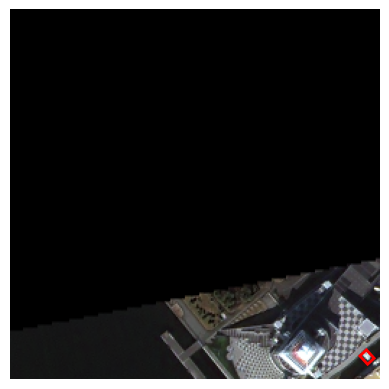

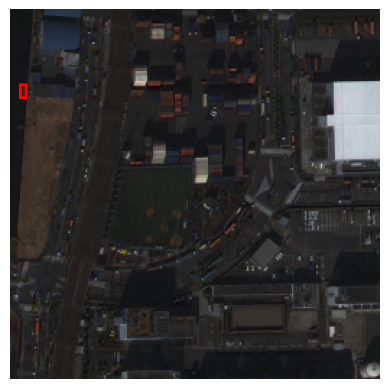

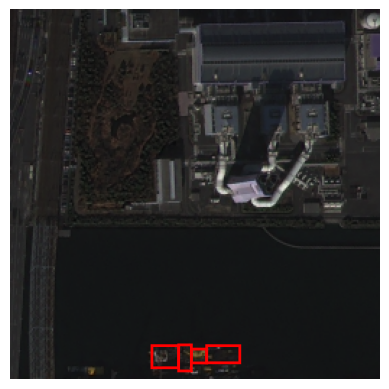

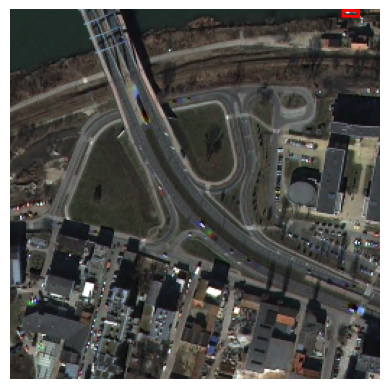

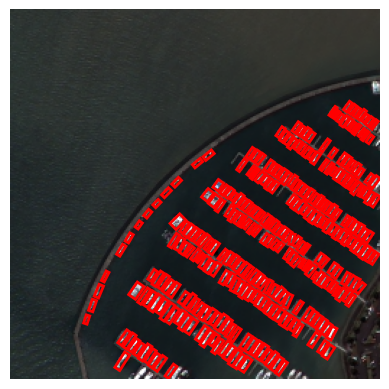

In [62]:
import os
import csv
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import numpy as np

# 유클리드 거리 계산 함수
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def manhattan_distance(coords):
    x_values = coords[0::2]  # 짝수 인덱스는 x 좌표
    y_values = coords[1::2]  # 홀수 인덱스는 y 좌표
    
    # 좌표로부터 bbox의 중심 좌표(cx, cy), 너비(width), 높이(height) 계산
    x_min = min(x_values)
    x_max = max(x_values)
    y_min = min(y_values)
    y_max = max(y_values)

    width = x_max - x_min
    height = y_max - y_min
    
    return width, height

'''
# JSON 파일을 읽어들이는 함수 (BBox 좌표와 angle 포함)
def get_bbox_from_json(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    results = []
    
    if 'features' in data:
        for feature in data['features']:
            if 'properties' in feature:
                # object_imcoords를 파싱하여 좌표 추출
                imcoords = feature['properties'].get('object_imcoords', '')
                if imcoords:
                    coords = list(map(float, imcoords.split(',')))

                    # 맨해튼 거리 계산
                    # width, height = manhattan_distance(coords)

                    coords = np.array(coords).reshape(-1, 2)  # 2D 좌표로 변환

                    # 중심 좌표 계산
                    cx = np.mean(coords[:, 0])
                    cy = np.mean(coords[:, 1])

                    # 인접한 두 점으로부터 너비와 높이 계산
                    width = euclidean_distance(coords[0], coords[1])
                    height = euclidean_distance(coords[1], coords[2])

                    # 각도 추출
                    angle = feature['properties'].get('object_angle', 0.0)

                    # 회전된 바운딩 박스 좌표 저장 (cx, cy, width, height, angle)
                    results.append((cx, cy, width, height, angle))
    
    return results
'''
# def get_coords_from_json(json_file):
#     with open(json_file, 'r', encoding='utf-8') as f:
#         data = json.load(f)
    
#     results = []
    
#     if 'features' in data:
#         for feature in range(len(data['features'])):
#             # object_imcoords를 파싱하여 좌표 추출
#             imcoords = feature.get('object_imcoords', '')
#             if imcoords:
#                 coords = list(map(float, imcoords.split(',')))

#                 results.append(coords)
#     return results
def get_coords_from_json(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    results = []
    
    if 'features' in data:
        for feature in data['features']:
            imcoords = feature.get('object_imcoords', None)
            if imcoords:
                # 좌표가 리스트로 되어 있는 경우
                if isinstance(imcoords, list):
                    coords = imcoords
                else:
                    coords = list(map(float, imcoords.split(',')))

                # 좌표가 8개인지 확인
                if len(coords) == 8:
                    results.append(coords)

    return results


def save_coords_to_txt(coords_list, output_file, img_path):
    with open(output_file, 'w') as f:
        for coords in coords_list:

            coords = np.array(coords) / 512.0
    
             # 각 좌표값이 0 미만이면 0, 1 이상이면 1로 클리핑
            coords = np.clip(coords, 0, 1)

            x1, y1, x2, y2, x3, y3, x4, y4 = coords
            
            
            f.write(f"0 {x1:.6f} {y1:.6f} {x2:.6f} {y2:.6f} {x3:.6f} {y3:.6f} {x4:.6f} {y4:.6f}\n")
'''
# 바운딩 박스 정보를 txt 파일로 저장하는 함수
def save_bbox_to_txt(bbox_list, output_file, img_path):
    with open(output_file, 'w') as f:
        for bbox in bbox_list:
            cx, cy, width, height, angle = bbox
            cx, cy, width, height, angle = cx/1024, cy/1024, width/1024, height/1024, angle

            # if cx < 0 or cy < 0 or width < 0 or height < 0 or cx > 1 or cy > 1 or width > 1 or height > 1:
                # print(f"Warning: {img_path} - bbox가 이미지 밖으로 벗어납니다.")
                # visualize_image_with_bbox(img_path, bbox_list)
            if cx < 0 or cx > 1:
                cx = max(0, min(cx, 1))
            if cy < 0 or cy > 1:
                cy = max(0, min(cy, 1))
            if width < 0 or width > 1:
                width = max(0, min(width, 1))
            if height < 0 or height > 1:
                height = max(0, min(height, 1))

            f.write(f"0 {cx:.6f} {cy:.6f} {height:.6f} {width:.6f} {angle:.6f}\n")
            # f.write(f"0 {cx:.6f} {cy:.6f} {height:.6f} {width:.6f}\n")
'''

def visualize_image_with_coords(image_path, coords_list):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # print(coords_list)
    for coords in coords_list:
        # coords: [x1, y1, x2, y2, x3, y3, x4, y4]
        coords = np.array(coords) / 2.0
        coords = coords.reshape(4, 2)  # 4개의 좌표쌍 (x, y)으로 변환
        # print(coords)
        # 다각형 그리기 (4개의 좌표를 사용한 회전된 바운딩 박스)
        polygon = patches.Polygon(coords, closed=True, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(polygon)
    
    plt.axis('off')
    plt.show()

# 이미지와 바운딩 박스를 시각화하는 함수
def visualize_image_with_bbox(image_path, bbox_list):
    # 이미지를 불러오기
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # 바운딩 박스 그리기
    for bbox in bbox_list:
        cx, cy, width, height, angle = bbox
        cx, cy, width, height, angle = cx, cy, width, height, 0

        # 바운딩 박스 좌표 계산 (중심 기준으로 회전)
        rect_coords = [
            [-width / 2, -height / 2],  # 좌상단
            [width / 2, -height / 2],   # 우상단
            [width / 2, height / 2],    # 우하단
            [-width / 2, height / 2]    # 좌하단
        ]

        # 회전 각도를 라디안으로 변환하여 회전 행렬 적용
        theta = np.radians(angle)
        theta = -theta  # 이미지에서 반시계 방향으로 회전하기 때문에 부호 반전
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_coords = np.dot(rect_coords, rotation_matrix)

        # 중심 좌표로 평행 이동
        rotated_coords[:, 0] += cx
        rotated_coords[:, 1] += cy

        # 회전된 좌표를 Polygon으로 시각화
        polygon = patches.Polygon(rotated_coords, closed=True, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(polygon)
    
    plt.axis('off')
    plt.show()

# CSV에서 이미지 경로와 JSON 경로를 불러오는 함수
def load_csv(csv_path):
    data = []
    with open(csv_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # 헤더 스킵
        for row in reader:
            img_path, json_path = row
            data.append((img_path, json_path))
    return data

# 사용 예시
csv_path = 'train.csv'  # CSV 파일 경로
data = load_csv(csv_path)  # 이미지와 JSON 경로 불러오기

# 5개의 이미지와 바운딩 박스를 시각화하고, BBox 정보를 txt로 저장
for i, (img_path, json_path) in enumerate(data):

    if os.path.exists(img_path) and os.path.exists(json_path):
        bbox_list = get_coords_from_json(json_path)  # JSON에서 BBox 추출
        # print(bbox_list)
        # 바운딩 박스 정보를 .txt 파일로 저장
        output_file = json_path.replace('.json', '.txt')  # .json 파일명을 .txt로 변경
        save_coords_to_txt(bbox_list, output_file, img_path)  # bbox 정보를 txt로 저장
        
        if i < 5:
            # 이미지와 BBox 시각화
            visualize_image_with_coords(img_path, bbox_list)


## Submission.csv Visualize

In [7]:
import os
import csv
from PIL import Image, ImageDraw
import numpy as np

def visualize_and_save_image_with_bbox(image_path, bbox_list, output_path):
    # 이미지를 불러오기
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)

    # 바운딩 박스 그리기
    for bbox in bbox_list:
        cx, cy, width, height, angle = bbox

        # 바운딩 박스 좌표 계산 (중심 기준으로 회전)
        rect_coords = [
            [-width / 2, -height / 2],  # 좌상단
            [width / 2, -height / 2],   # 우상단
            [width / 2, height / 2],    # 우하단
            [-width / 2, height / 2]    # 좌하단
        ]

        # 회전 각도를 라디안으로 변환하여 회전 행렬 적용
        theta = np.radians(angle)
        theta = -theta  # 이미지에서 반시계 방향으로 회전하기 때문에 부호 반전
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_coords = np.dot(rect_coords, rotation_matrix)

        # 중심 좌표로 평행 이동
        rotated_coords[:, 0] += cx
        rotated_coords[:, 1] += cy

        # 각 좌표를 튜플로 변환하여 그리기
        polygon_coords = [tuple(coord) for coord in rotated_coords]
        draw.polygon(polygon_coords, outline="red", width=2)
    
    # 결과 이미지 보여주기
    img.show()

    # 원본 크기로 저장
    img.save(output_path)
    print(f"Image saved as {output_path}")

# CSV에서 바운딩 박스 정보를 불러오는 함수
def load_csv(csv_path):
    data = []
    with open(csv_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # 헤더 스킵
        for row in reader:
            _, cx, cy, width, height, angle = row
            cx, cy, width, height, angle = float(cx), float(cy), float(width), float(height), float(angle)
            data.append((cx, cy, width, height, angle))
        
    return data

# 사용 예시
csv_path = 'submission.csv'  # CSV 파일 경로
img_path = 'sample.png'
output_path = 'D:/Workspace/output2.png'  # 저장할 파일 경로
data = load_csv(csv_path)  # 바운딩 박스 데이터 불러오기

# 이미지 위에 모든 바운딩 박스 표시하고 원본 크기로 저장
visualize_and_save_image_with_bbox(img_path, data, output_path)



Image saved as D:/Workspace/output2.png


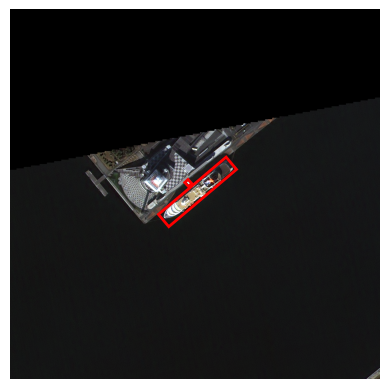

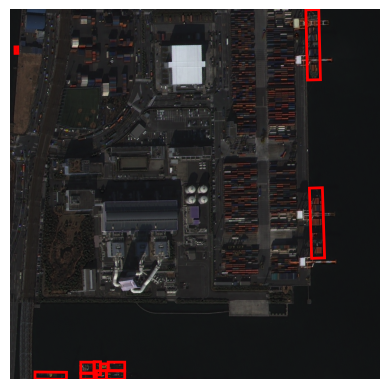

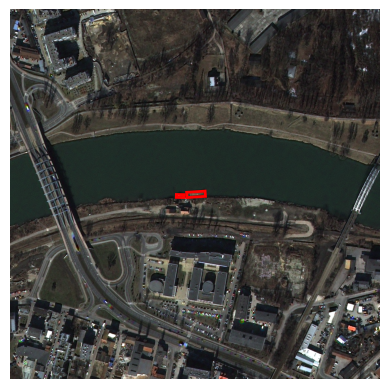

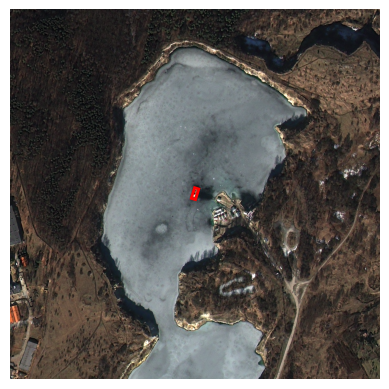

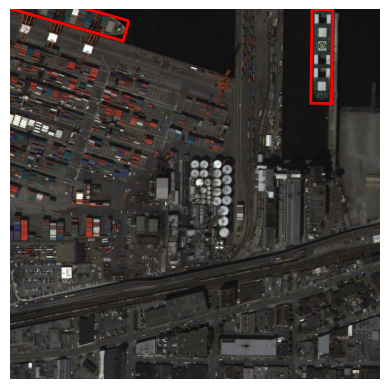

In [49]:
import os
import csv
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import numpy as np

# 유클리드 거리 계산 함수
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

# JSON 파일을 읽어들이는 함수 (BBox 좌표와 angle 포함)
def get_bbox_from_json(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    results = []
    
    if 'features' in data:
        for feature in data['features']:
            if 'properties' in feature:
                # object_imcoords를 파싱하여 좌표 추출
                imcoords = feature['properties'].get('object_imcoords', '')
                if imcoords:
                    coords = list(map(float, imcoords.split(',')))
                    coords = np.array(coords).reshape(-1, 2)  # 2D 좌표로 변환

                    # 중심 좌표 계산
                    cx = np.mean(coords[:, 0])
                    cy = np.mean(coords[:, 1])

                    # 인접한 두 점으로부터 너비와 높이 계산
                    width = euclidean_distance(coords[0], coords[1])
                    height = euclidean_distance(coords[1], coords[2])

                    # 각도 추출
                    angle = feature['properties'].get('object_angle', 0.0)

                    # 회전된 바운딩 박스 좌표 저장 (cx, cy, width, height, angle)
                    results.append((cx, cy, width, height, angle))

    return results

# 이미지와 바운딩 박스를 시각화하는 함수
def visualize_image_with_bbox(image_path, bbox_list):
    # 이미지를 불러오기
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # 바운딩 박스 그리기
    for bbox in bbox_list:
        cx, cy, width, height, angle = bbox

        # 바운딩 박스 좌표 계산 (중심 기준으로 회전)
        rect_coords = [
            [-width / 2, -height / 2],  # 좌상단
            [width / 2, -height / 2],   # 우상단
            [width / 2, height / 2],    # 우하단
            [-width / 2, height / 2]    # 좌하단
        ]

        # 회전 각도를 라디안으로 변환하여 회전 행렬 적용
        theta = np.radians(angle)
        theta = -theta  # 이미지에서 반시계 방향으로 회전하기 때문에 부호 반전
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_coords = np.dot(rect_coords, rotation_matrix)

        # 중심 좌표로 평행 이동
        rotated_coords[:, 0] += cx
        rotated_coords[:, 1] += cy

        # 회전된 좌표를 Polygon으로 시각화
        polygon = patches.Polygon(rotated_coords, closed=True, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(polygon)
    
    plt.axis('off')
    plt.show()

# CSV에서 이미지 경로와 JSON 경로를 불러오는 함수
def load_csv(csv_path):
    data = []
    with open(csv_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # 헤더 스킵
        for row in reader:
            img_path, json_path = row
            data.append((img_path, json_path))
    return data

# 사용 예시
csv_path = 'train.csv'  # CSV 파일 경로
data = load_csv(csv_path)  # 이미지와 JSON 경로 불러오기

# 5개의 이미지와 바운딩 박스를 시각화
for i, (img_path, json_path) in enumerate(data):
    if i >= 5:
        break
    if os.path.exists(img_path) and os.path.exists(json_path):
        bbox_list = get_bbox_from_json(json_path)  # JSON에서 BBox 추출
        visualize_image_with_bbox(img_path, bbox_list)  # 이미지와 BBox 시각화


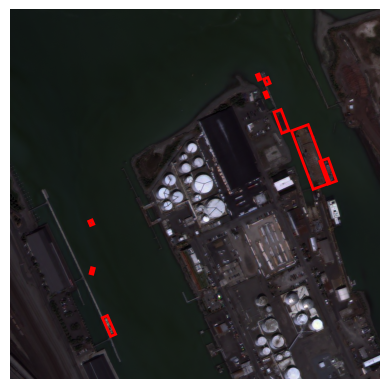

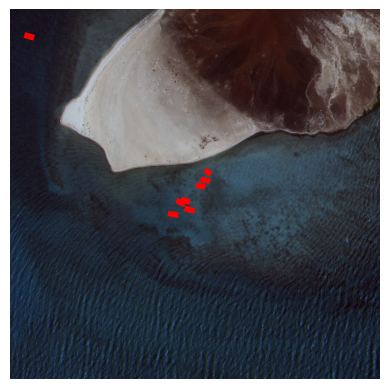

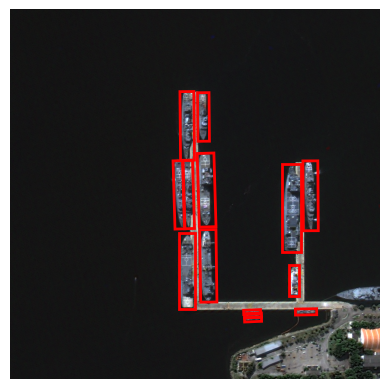

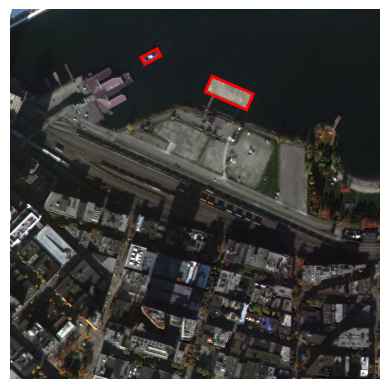

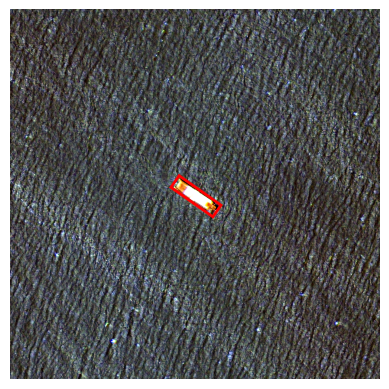

In [50]:
# 사용 예시
csv_path = 'valid.csv'  # CSV 파일 경로
data = load_csv(csv_path)  # 이미지와 JSON 경로 불러오기

# 5개의 이미지와 바운딩 박스를 시각화
for i, (img_path, json_path) in enumerate(data):
    if i >= 5:
        break
    if os.path.exists(img_path) and os.path.exists(json_path):
        bbox_list = get_bbox_from_json(json_path)  # JSON에서 BBox 추출
        visualize_image_with_bbox(img_path, bbox_list)  # 이미지와 BBox 시각화